<a href="https://colab.research.google.com/github/wikimacd/searchfromgeneontology/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pwd

'/content'

In [ ]:
ls

drive/  sample_data/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_excel(r'/content/drive/MyDrive/Z_Macdonald.xlsx')
df['total']=df['title']+' '+df['abstract_text']
df = df[df['abstract_text'].notna()]
df = df[df['Germline'].notna()]
df = df[df['Somatic'].notna()]
df['Somatic'] = df['Somatic'].astype(int)
df['Germline'] = df['Germline'].astype(int)
df = df[["total", "Somatic", "Germline"]]
df.head()

,total,Somatic,Germline
0,Hereditary Diffuse Gastric Cancer Syndrome: CD...,0,1
1,"Cancer mortality among Chinese, Japanese, and ...",0,0
2,Relative risk of stump cancer following partia...,0,0
3,[Endoscopic diagnosis of carcinoma in the oper...,0,0
4,Hereditary Cancer Syndromes-A Primer on Diagno...,0,1


In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df)) ])

In [ ]:
len(train), len(val), len(test)

(9224, 1153, 1153)

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('Somatic')
  df = df["total"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds


In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 128), dtype=float32, numpy=
array([[ 1.096063  , -0.11444066,  0.29751775, ..., -0.07332354,
        -0.30304757, -0.03423122],
       [ 0.74963033, -0.24157274,  0.09314375, ...,  0.1308609 ,
        -0.15593593, -0.1469553 ],
       [ 1.4303917 , -0.07751013,  0.2736061 , ...,  0.09354986,
        -0.02563997,  0.03012243],
       ...,
       [ 1.1413834 ,  0.05989196,  0.00505021, ...,  0.08881167,
        -0.05100598,  0.04180623],
       [ 0.8101009 , -0.25983986, -0.24739666, ...,  0.19847783,
        -0.32761806, -0.14694415],
       [ 0.7292805 , -0.5304714 , -0.06232394, ...,  0.30322987,
        -0.12223639, -0.08565474]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

10/10 [==============================] - 2s 195ms/step - loss: 0.6220 - accuracy: 0.7162


[0.6219721436500549, 0.7161751985549927]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
10/10 [==============================] - 17s 2s/step - loss: 0.6349 - accuracy: 0.6688 - val_loss: 0.6188 - val_accuracy: 0.6878
Epoch 2/5
10/10 [==============================] - 15s 1s/step - loss: 0.6273 - accuracy: 0.6782 - val_loss: 0.6091 - val_accuracy: 0.6878
Epoch 3/5
10/10 [==============================] - 15s 1s/step - loss: 0.6105 - accuracy: 0.6905 - val_loss: 0.6005 - val_accuracy: 0.6878
Epoch 4/5
10/10 [==============================] - 16s 2s/step - loss: 0.6056 - accuracy: 0.6922 - val_loss: 0.5937 - val_accuracy: 0.6878
Epoch 5/5
10/10 [==============================] - 21s 2s/step - loss: 0.6023 - accuracy: 0.6961 - val_loss: 0.5872 - val_accuracy: 0.6878


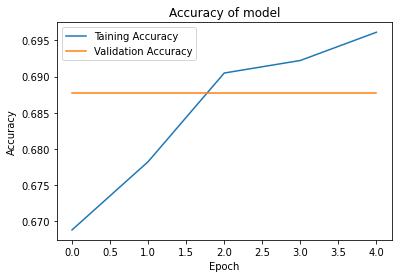

In [ ]:
plt.plot(history.history['accuracy'], label="Taining Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

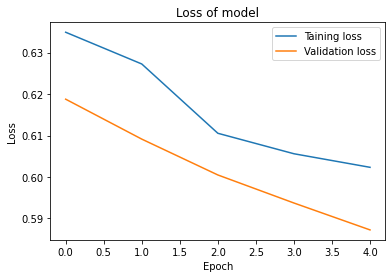

In [ ]:
plt.plot(history.history['loss'], label="Taining loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'of', 'the', 'and', 'in', 'cancer', 'with', 'a', 'to',
       'for', 'were', 'was', 'patients', 'mutations', 'risk', 'breast',
       'is', 'mutation', 'or'], dtype='<U20')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')   
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

2/2 [==============================] - 1s 121ms/step - loss: 0.6935 - accuracy: 0.4415


[0.6934607028961182, 0.441457062959671]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
10/10 [==============================] - 49s 4s/step - loss: 0.6925 - accuracy: 0.5528 - val_loss: 0.6913 - val_accuracy: 0.6730
Epoch 2/5
10/10 [==============================] - 40s 4s/step - loss: 0.6901 - accuracy: 0.6865 - val_loss: 0.6891 - val_accuracy: 0.6860
Epoch 3/5
10/10 [==============================] - 39s 4s/step - loss: 0.6875 - accuracy: 0.7121 - val_loss: 0.6867 - val_accuracy: 0.6878
Epoch 4/5
10/10 [==============================] - 45s 5s/step - loss: 0.6846 - accuracy: 0.7170 - val_loss: 0.6841 - val_accuracy: 0.6878
Epoch 5/5
10/10 [==============================] - 46s 5s/step - loss: 0.6814 - accuracy: 0.7178 - val_loss: 0.6812 - val_accuracy: 0.6878


In [ ]:
model.evaluate(train_data)

10/10 [==============================] - 13s 1s/step - loss: 0.6794 - accuracy: 0.7176


[0.6793749332427979, 0.7175845503807068]